In [5]:
# Import modules
import numpy as np

# Import functions
from assembly_A_local_global_matrices import *
from assembly_K_matrices import *
from assembly_B_matrices import *
from assembly_f_vectors import *
from RegularSudomainsMesh import RegularSubdomainsMesh
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Import data
d_dat = np.genfromtxt('data/d.dat')
fP_dat = np.genfromtxt('data/fP.dat')
fr_dat = np.genfromtxt('data/fr.dat')
Ks = np.genfromtxt('data/localK.dat')
solution = np.genfromtxt('data/solution.dat')

In [7]:
# Initial data
# Number of subdomains
Nsub_x = 4
Nsub_y = 3

# Number of remaining nodes in each subdomain
Nr_x = 4
Nr_y = 3

# Local remaining and primal indices
rs = np.array([1, 2, 4, 5, 6, 7, 9, 10])
qs = np.array([0, 3, 8, 11])

In [8]:
# Create mesh
mesh = RegularSubdomainsMesh(Nsub_x, Nsub_y, Nr_x, Nr_y)

In [9]:
# Transformation matrices A
# Primal nodes local-global transformation matrices
APq = create_APq_matrices(mesh)

# Remaining nodes local-global transformation matrices
ARr = create_ARr_matrices(mesh)

In [10]:
# Stiffness matrices K
KRR = assembly_KRR_matrix(Ks, ARr, rs, mesh)
KPP = assembly_KPP_matrix(Ks, APq, qs, mesh)
KRP = assembly_KRP_matrix(Ks, APq, ARr, qs, rs, mesh)
KPR = KRP.T

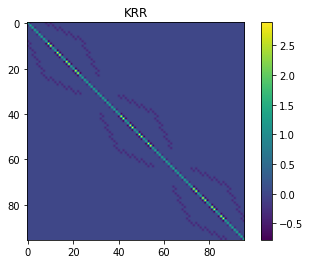

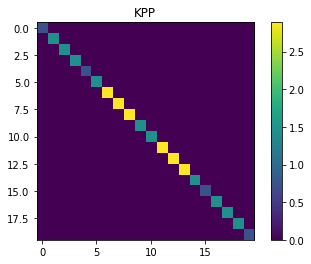

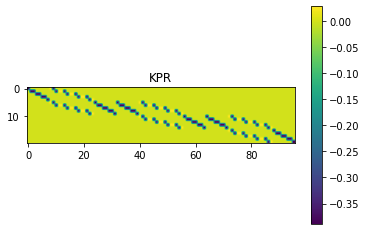

In [11]:
# Plot K matrices
plot_sparse_matrix(KRR, 'KRR')
plot_sparse_matrix(KPP, 'KPP')
plot_sparse_matrix(KPR, 'KPR')

In [12]:
# Assembly B matrices
BlambdaR = assembly_BR_matrix(mesh, ARr)

# Dirichlet boundary conditions
# Left wall remaining
BlambdaR = assembly_Dirichlet_BR_matrix(mesh, ARr, BlambdaR)

#Left wall primal
BlambdaP = assembly_Dirichlet_BP_matrix(mesh, APq)

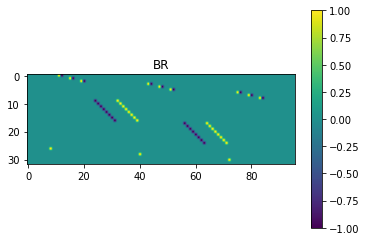

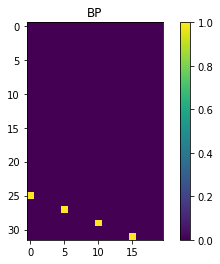

In [13]:
# Plot B matrices
plot_sparse_matrix(BlambdaR, 'BR')
plot_sparse_matrix(BlambdaP, 'BP')

In [14]:
# Assembly d vector
d = np.zeros(mesh.Nlambda)
d[mesh.NlambdaR:] = d_dat

In [15]:
# Assembly f vectors
# fP
fP = fP_dat

# fR
fR = assembly_fR_vector(mesh, fr_dat)

In [16]:
# Matrices pre computation
KRR_inv = np.linalg.inv(KRR)

SPP = KPP - KPR @ KRR_inv @ KRP
SPP_inv = np.linalg.inv(SPP)

fPH = fP - KPR @ KRR_inv @ fR

dH = -d \
    + BlambdaP @ SPP_inv @ fPH \
    + BlambdaR @ KRR_inv @ fR \
    - BlambdaR @ KRR_inv @ KRP @ SPP_inv @ fPH

F = BlambdaR @ KRR_inv @ BlambdaR.T \
    + BlambdaR @ KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T \
    + BlambdaP @ SPP_inv @ BlambdaP.T \
    - BlambdaP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T \
    - BlambdaR @ KRR_inv @ KRP @ SPP_inv @ BlambdaP.T

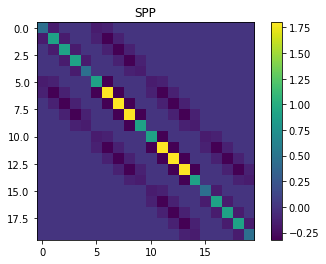

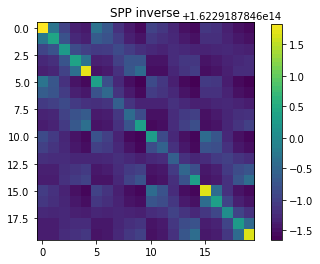

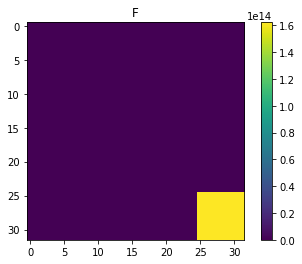

In [17]:
# Print some matrices
plot_sparse_matrix(SPP, 'SPP')
plot_sparse_matrix(SPP_inv, 'SPP inverse')
plot_sparse_matrix(F, 'F')

In [18]:
# Solve lambda linear system
lambda_ = np.linalg.solve(F, dH)

In [19]:
# Compute u
# uP
uP = SPP_inv @ fPH \
    + SPP_inv @ KPR @ KRR_inv @ BlambdaR.T @ lambda_ \
    - SPP_inv @ BlambdaP.T @ lambda_

# uR
uR = KRR_inv @ fR \
    + KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ fR \
    - KRR_inv @ KRP @ SPP_inv @ fP \
    - KRR_inv @ KRP @ SPP_inv @ KPR @ KRR_inv @ BlambdaR.T @ lambda_ \
    + KRR_inv @ KRP @ SPP_inv @ BlambdaP.T @ lambda_ \
    - KRR_inv @ BlambdaR.T @ lambda_

In [34]:
# Print result
print('uP', uP)
print('uR', uR)

uP [0.875   2.75    3.6875  4.375   4.34375 1.9375  3.      3.8125  4.21875
 4.46875 2.90625 3.4375  3.9375  4.3125  4.4375  3.875   3.6875  4.0625
 4.34375 4.375  ]
uR [1.78590397 2.39202086 3.22802862 3.34396906 4.16990749 4.29323997
 4.31766814 4.39934448 1.39077087 1.97948151 2.64722356 3.04614357
 2.84729466 3.22522568 3.48384941 3.62134656 4.04513916 4.22907076
 4.11114708 4.30926138 4.24661906 4.37795435 4.46223319 4.49410528
 2.29730473 2.71133688 3.19016821 3.56615249 4.3268358  4.34884319
 4.35935968 4.37717056 2.33973807 2.74870635 3.5442061  3.80487595
 3.99384971 4.17576979 4.21880694 4.3616844  2.3970872  2.93637399
 2.98211694 3.30818014 3.32939678 3.56261023 3.93609284 4.10828852
 3.97331918 4.11496965 4.23244423 4.28727208 4.26427683 4.28908262
 4.33877621 4.30688805 3.1963817  3.24599887 3.7467917  4.09923943
 4.15021574 4.22681475 4.33411172 4.31888826 3.25058978 3.44007139
 3.64024677 3.76335627 4.06717384 4.13998512 4.3789752  4.45546612
 3.47999327 3.50895369 3.43

In [35]:
# TODO: Set solutions uP and uR together in a single array u